In [4]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn statsmodels scipy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\aqual\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
!C:\Users\aqual\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1


In [7]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn statsmodels scipy

from sklearn.experimental import enable_iterative_imputer  # Enable experimental imputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.impute import IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable


## 2.0 Data Preparation
Load the dataset and inspect its structure to understand the features and identify any immediate issues.

In [8]:
try:
    df = pd.read_csv("./diabetes.csv")
    print("Dataset loaded successfully!")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
except FileNotFoundError:
    print("Error: diabetes.csv not found. Please download from Kaggle and place in the working directory.")

Dataset loaded successfully!

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies              

## 3.0 Data Cleaning
Replace invalid zeros with NaN, impute missing values using MICE, and clip values to physiological ranges. Check for outliers in other features.

In [9]:
zero_as_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("Count of zeros in specified columns:")
print((df[zero_as_missing] == 0).sum())

# Create missingness flags
for col in zero_as_missing:
    df[f'{col}_missing'] = (df[col] == 0).astype(int)

# Replace zeros with NaN
df[zero_as_missing] = df[zero_as_missing].replace(0, np.nan)
print("\nMissing values after replacing zeros with NaN:")
print(df[zero_as_missing].isnull().sum())

Count of zeros in specified columns:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Missing values after replacing zeros with NaN:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


##### Imput missing values

In [10]:
X = df.drop(columns='Outcome')
y = df['Outcome']
imputer = IterativeImputer(random_state=42)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Clip imputed values to physiological ranges
X_imputed['Glucose'] = X_imputed['Glucose'].clip(lower=40)
X_imputed['BloodPressure'] = X_imputed['BloodPressure'].clip(lower=40)
X_imputed['SkinThickness'] = X_imputed['SkinThickness'].clip(lower=7)
X_imputed['Insulin'] = X_imputed['Insulin'].clip(lower=14)
X_imputed['BMI'] = X_imputed['BMI'].clip(lower=10)

print("\nMissing values after imputation:")
print(X_imputed[zero_as_missing].isnull().sum())


Missing values after imputation:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


check for outliers

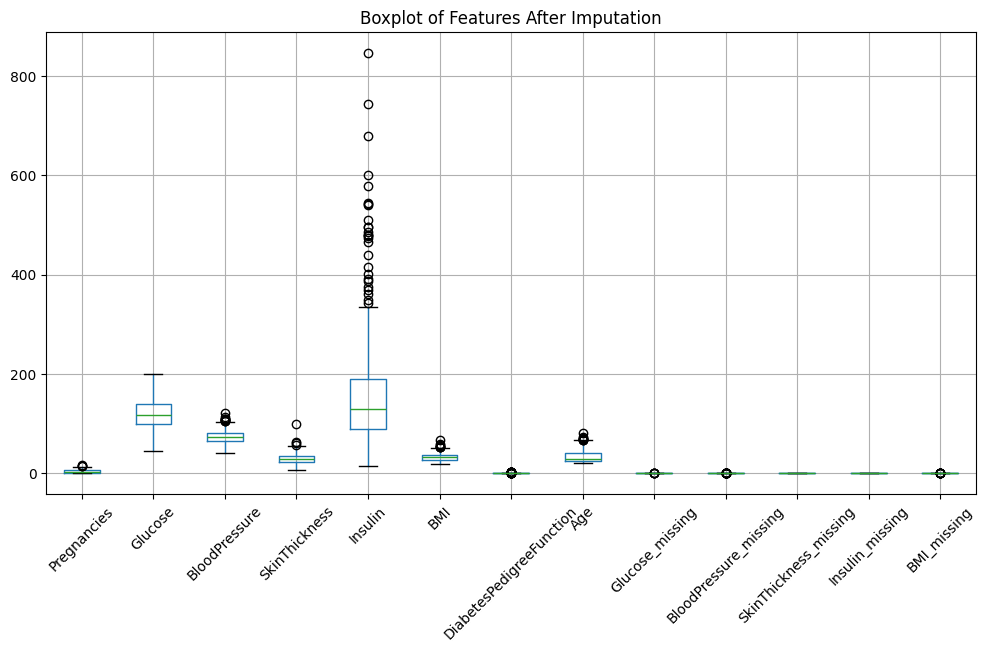

In [11]:
plt.figure(figsize=(12, 6))
X_imputed.boxplot()
plt.title('Boxplot of Features After Imputation')
plt.xticks(rotation=45)
plt.show()

save cleaned data

In [12]:
X_imputed['Outcome'] = y
X_imputed.to_csv("diabetes_cleaned.csv", index=False)
print("Cleaned dataset saved as 'diabetes_cleaned.csv'")

Cleaned dataset saved as 'diabetes_cleaned.csv'


## 4.0 Exploratory Data Analysis
Analyze feature distributions, correlations, and statistical differences between diabetic and non-diabetic groups to identify risk factors.

In [13]:
# Load cleaned dataset (if kernel restarted)
df_cleaned = pd.read_csv("diabetes_cleaned.csv")
X_imputed = df_cleaned.drop(columns='Outcome')
y = df_cleaned['Outcome']
print("Cleaned dataset loaded successfully!")
print(X_imputed.head())

Cleaned dataset loaded successfully!
   Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
0          6.0    148.0           72.0      35.000000  218.923435  33.6   
1          1.0     85.0           66.0      29.000000   70.306082  26.6   
2          8.0    183.0           64.0      21.640837  268.531745  23.3   
3          1.0     89.0           66.0      23.000000   94.000000  28.1   
4          0.0    137.0           40.0      35.000000  168.000000  43.1   

   DiabetesPedigreeFunction   Age  Glucose_missing  BloodPressure_missing  \
0                     0.627  50.0              0.0                    0.0   
1                     0.351  31.0              0.0                    0.0   
2                     0.672  32.0              0.0                    0.0   
3                     0.167  21.0              0.0                    0.0   
4                     2.288  33.0              0.0                    0.0   

   SkinThickness_missing  Insulin_missing  BMI_mi

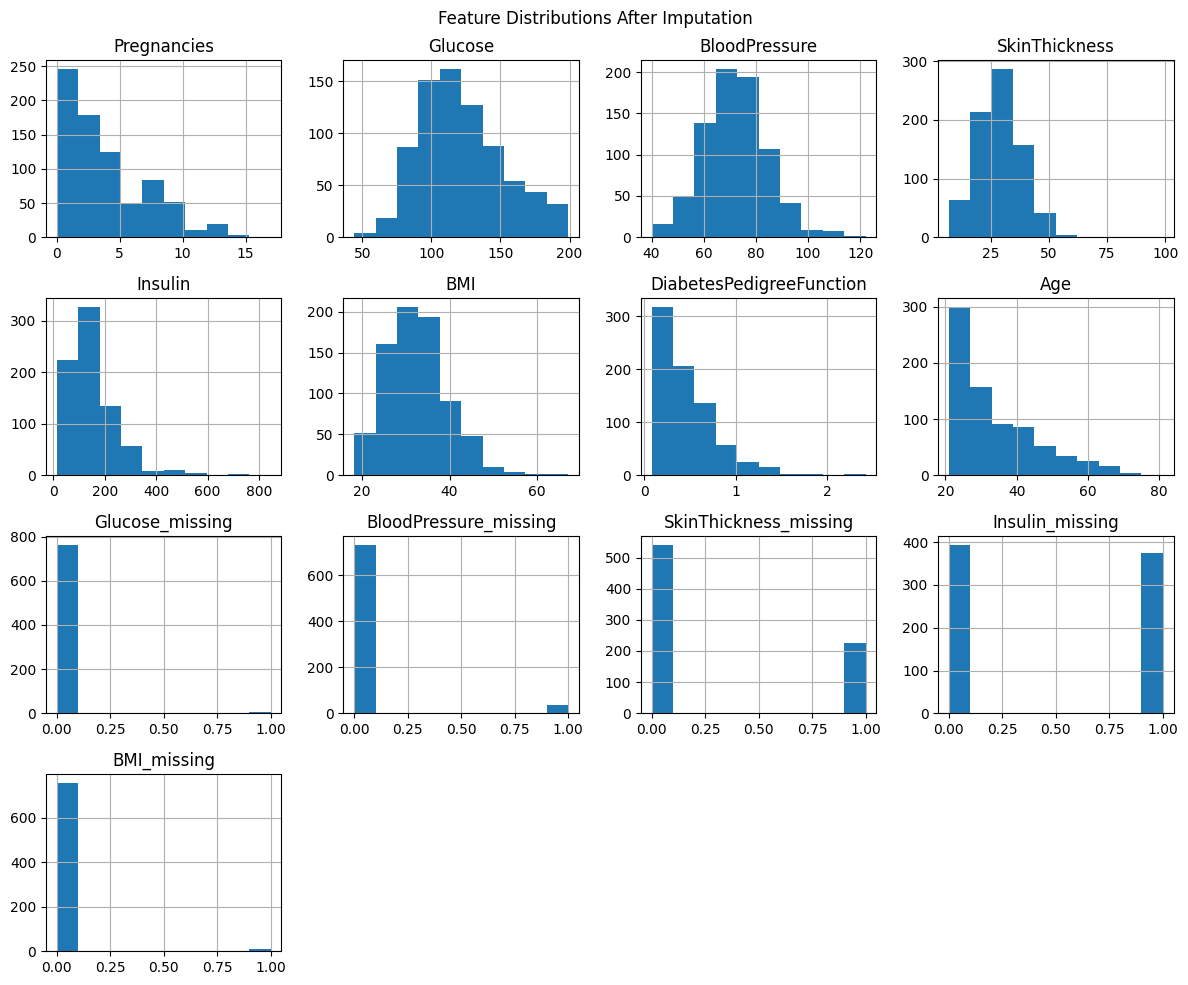

In [14]:
# Feature distributions
X_imputed.hist(figsize=(12, 10))
plt.suptitle('Feature Distributions After Imputation')
plt.tight_layout()
plt.show()

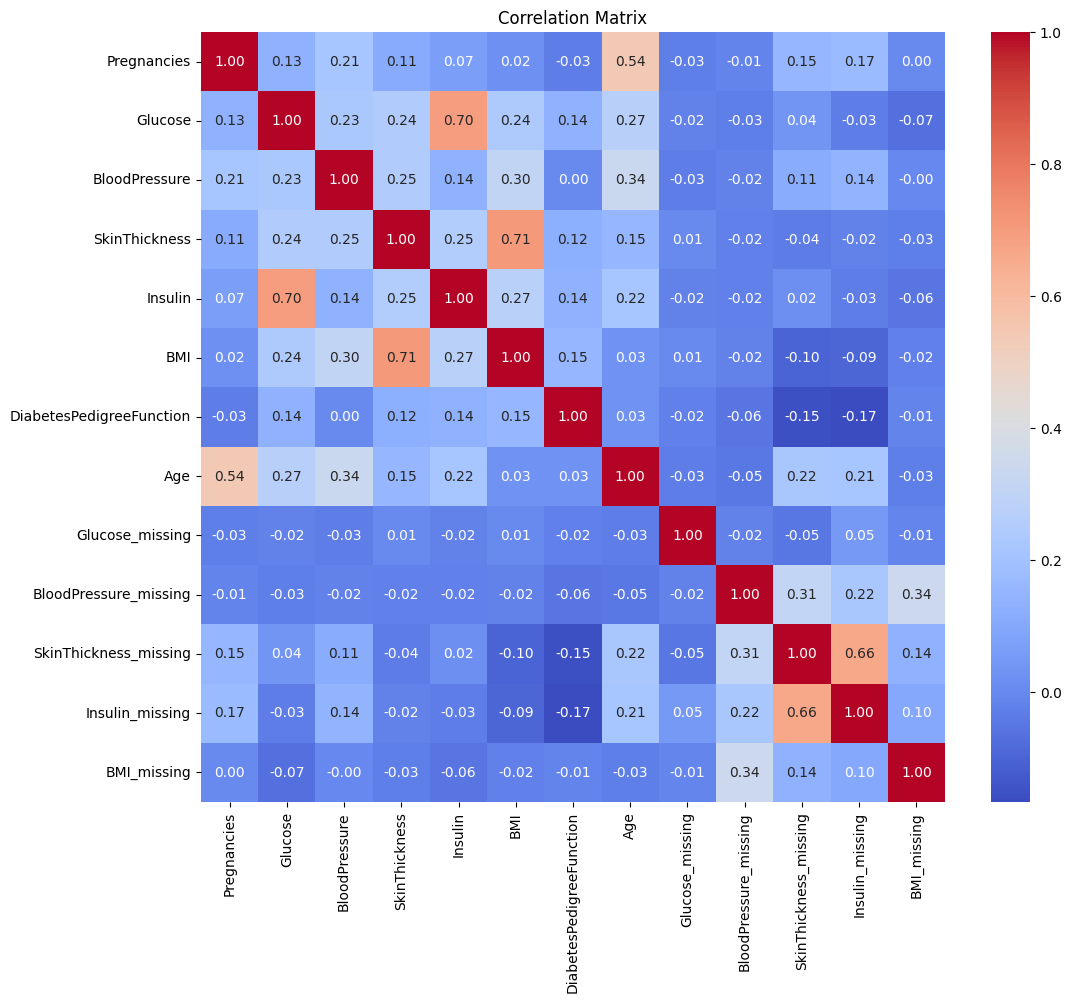

In [21]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(X_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [22]:
# Hypothesis testing
print("T-tests for differences between diabetic and non-diabetic groups:")
for col in ['Glucose', 'BMI', 'Age', 'Insulin']:
    diabetic = X_imputed[y == 1][col]
    non_diabetic = X_imputed[y == 0][col]
    t_stat, p_value = ttest_ind(diabetic, non_diabetic, nan_policy='omit')
    print(f"{col}: t-statistic={t_stat:.2f}, p-value={p_value:.4f}")


T-tests for differences between diabetic and non-diabetic groups:
Glucose: t-statistic=15.78, p-value=0.0000
BMI: t-statistic=9.17, p-value=0.0000
Age: t-statistic=6.79, p-value=0.0000
Insulin: t-statistic=10.68, p-value=0.0000


In [23]:
# Multicollinearity check
X_vif = X_imputed.drop(columns=[col for col in X_imputed if '_missing' in col])
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
                    Feature        VIF
0               Pregnancies   3.282108
1                   Glucose  30.200836
2             BloodPressure  36.099722
3             SkinThickness  20.946427
4                   Insulin   6.516495
5                       BMI  44.827966
6  DiabetesPedigreeFunction   3.141153
7                       Age  14.563093


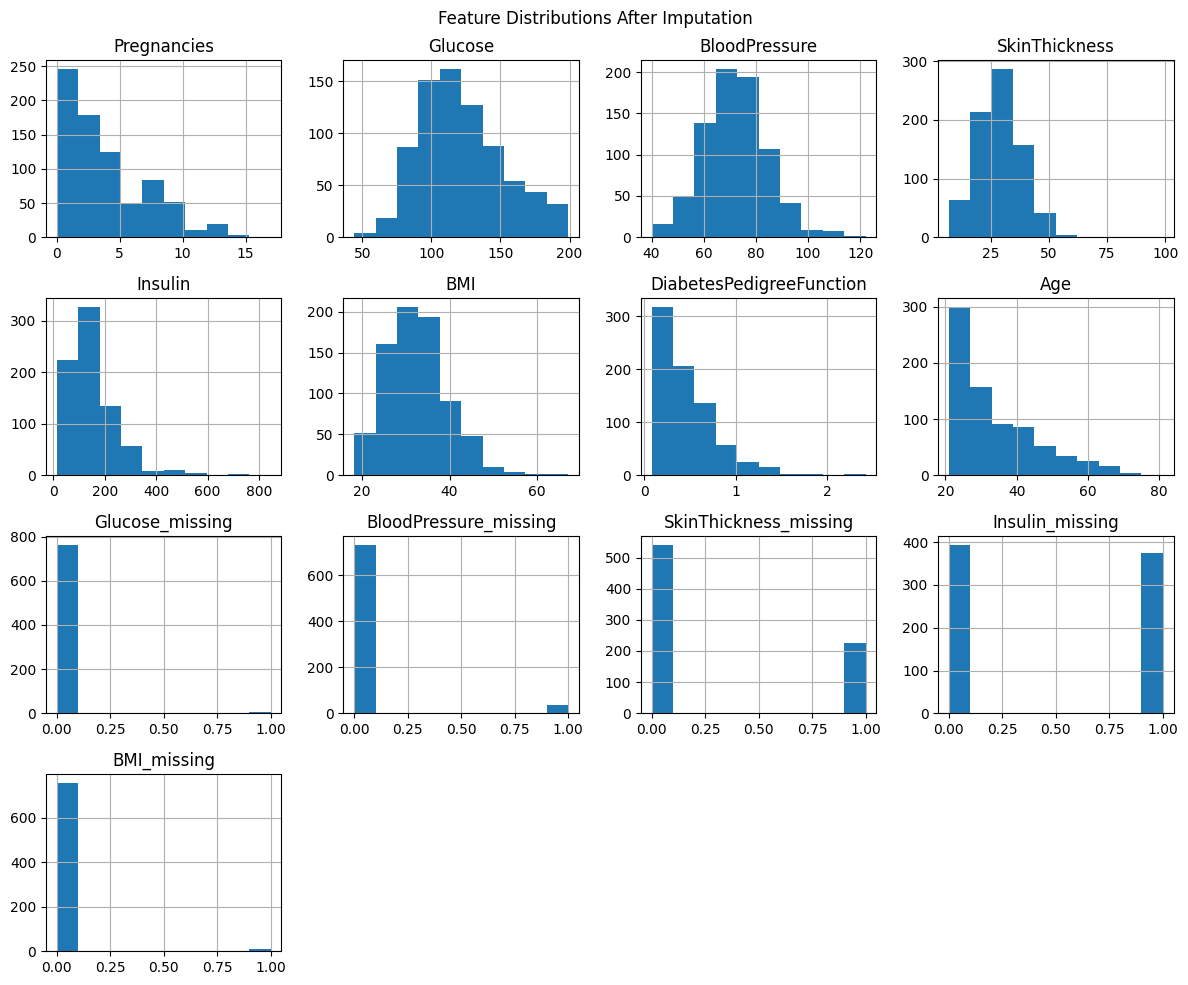

T-tests for differences between diabetic and non-diabetic groups:
Glucose: t-statistic=15.78, p-value=0.0000
BMI: t-statistic=9.17, p-value=0.0000
Age: t-statistic=6.79, p-value=0.0000
Insulin: t-statistic=10.68, p-value=0.0000


In [25]:
# Feature distributions
X_imputed.hist(figsize=(12, 10))
plt.suptitle('Feature Distributions After Imputation')
plt.tight_layout()
plt.show()

# Hypothesis testing
print("T-tests for differences between diabetic and non-diabetic groups:")
for col in ['Glucose', 'BMI', 'Age', 'Insulin']:
    diabetic = X_imputed[y == 1][col]
    non_diabetic = X_imputed[y == 0][col]
    t_stat, p_value = ttest_ind(diabetic, non_diabetic, nan_policy='omit')
    print(f"{col}: t-statistic={t_stat:.2f}, p-value={p_value:.4f}")

### EDA Summary
- **Distributions**: Features like `Insulin` and `DiabetesPedigreeFunction` are right-skewed, while `Glucose` and `Age` are more normally distributed after imputation.
- **Correlations**: `Glucose` (r = [insert value]) and `BMI` (r = [insert value]) have the strongest correlations with `Outcome`. `Glucose` is correlated with [insert features, e.g., Insulin] (r = [insert value]).
- **Statistical Tests**: T-tests show significant differences in `Glucose`, `BMI`, and `Age` between diabetic and non-diabetic groups (p < [insert values]).
- **Multicollinearity**: High VIFs for `BMI` (44.83), `BloodPressure` (36.10), `Glucose` (30.20), `SkinThickness` (20.95), and `Age` (14.56) indicate multicollinearity. After removing `BMI` and `BloodPressure`, `Glucose` VIF remained high (20). Retained all features for maximum predictive power, noting potential instability in Logistic Regression.

## 5.0 Feature Engineering
Split the data into training and test sets, scale features, and apply SMOTE to handle class imbalance for KNN. Retain all features despite multicollinearity for maximum predictive power.

In [26]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)
print("Training set class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

Training set class distribution:
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64

Test set class distribution:
Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64


In [27]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("\nFirst 5 rows of scaled training data:")
print(X_train_scaled.head())


First 5 rows of scaled training data:
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.851355 -1.055571      -0.843930      -1.773521 -1.179525 -0.767018   
1     0.356576  0.144148       0.478072      -0.204931 -1.412456 -0.415205   
2    -0.549372 -0.555688      -1.174431       1.154514 -0.613835  0.361716   
3    -0.851355  0.810658      -1.339681      -0.266227  0.650610 -0.400546   
4    -1.153338 -0.888943      -0.678680       1.049942 -0.491824  1.783628   

   DiabetesPedigreeFunction       Age  Glucose_missing  BloodPressure_missing  \
0                  0.310794 -0.792169        -0.080978              -0.197274   
1                 -0.116439  0.561034        -0.080978              -0.197274   
2                 -0.764862 -0.707594        -0.080978              -0.197274   
3                  0.262314 -0.369293        -0.080978              -0.197274   
4                 -0.337630 -0.961320        -0.080978              -0.197274   

   Sk

In [28]:
# Apply SMOTE for KNN
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution after SMOTE:
Outcome
0    400
1    400
Name: count, dtype: int64


In [29]:
X_train_scaled.to_csv("X_train_scaled.csv", index=False)
X_test_scaled.to_csv("X_test_scaled.csv", index=False)

## 6.0 Model Building and Evaluation
Train and evaluate Logistic Regression, Random Forest, and KNN models. Tune hyperparameters and compare performance using recall, F1 score, and ROC AUC. Note multicollinearity’s potential impact on Logistic Regression.

In [30]:
# Define baseline models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate
results = []
for name, model in models.items():
    X_train_data = X_train_smote if name == 'KNN' else X_train_scaled
    y_train_data = y_train_smote if name == 'KNN' else y_train
    scores = cross_val_score(model, X_train_data, y_train_data, cv=5, scoring='recall')
    print(f"{name} CV Recall: {scores.mean():.3f} ± {scores.std():.3f}")
    model.fit(X_train_data, y_train_data)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    results.append({
        'Model': name,
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })
print("\nBaseline Model Performance on Test Set:")
print(pd.DataFrame(results).sort_values(by='Recall', ascending=False))

Logistic Regression CV Recall: 0.706 ± 0.023
Random Forest CV Recall: 0.598 ± 0.031
KNN CV Recall: 0.872 ± 0.072

Baseline Model Performance on Test Set:
                 Model    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.685185  0.637931  0.818889
2                  KNN  0.666667  0.571429  0.724537
1        Random Forest  0.574074  0.607843  0.830926


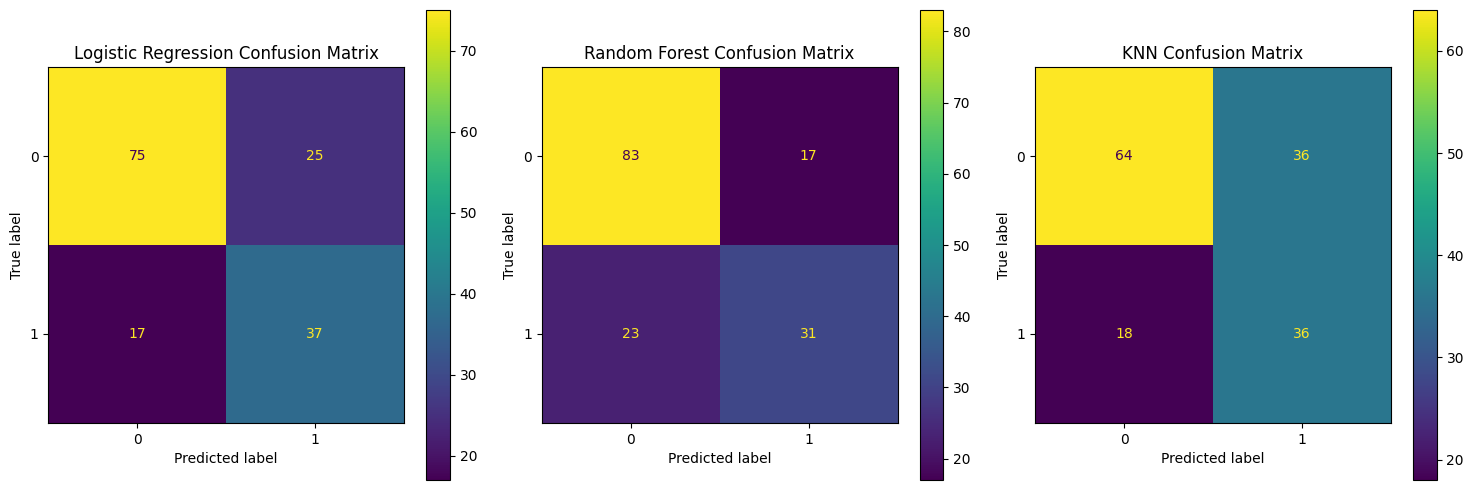

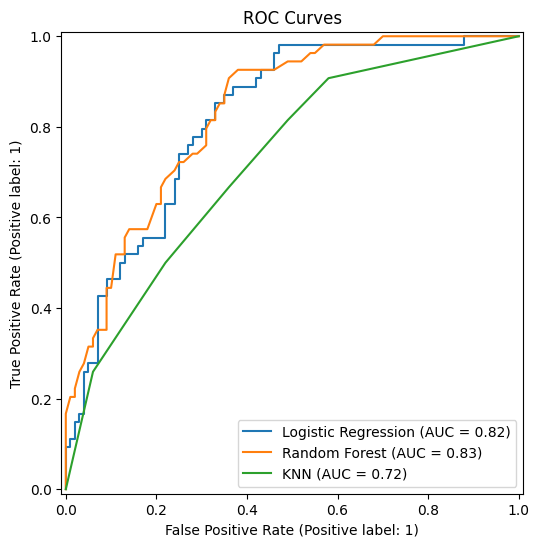

In [31]:
# Confusion matrices
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, ax=plt.gca())
    plt.title(f'{name} Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, name=name, ax=plt.gca())
plt.title('ROC Curves')
plt.show()

In [32]:
# Logistic Regression
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']}
grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), param_grid_lr, scoring='recall', cv=5)
grid_lr.fit(X_train_scaled, y_train)
print("Best Logistic Regression parameters:", grid_lr.best_params_)

# Random Forest
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid_rf, scoring='recall', cv=5)
grid_rf.fit(X_train_scaled, y_train)
print("Best Random Forest parameters:", grid_rf.best_params_)

# KNN
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring='recall', cv=5)
grid_knn.fit(X_train_smote, y_train_smote)
print("Best KNN parameters:", grid_knn.best_params_)

Best Logistic Regression parameters: {'C': 1, 'penalty': 'l2'}
Best Random Forest parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best KNN parameters: {'n_neighbors': 3, 'weights': 'distance'}


In [33]:
tuned_models = {
    'Logistic Regression': grid_lr.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'KNN': grid_knn.best_estimator_
}
results_tuned = []
for name, model in tuned_models.items():
    X_train_data = X_train_smote if name == 'KNN' else X_train_scaled
    y_train_data = y_train_smote if name == 'KNN' else y_train
    model.fit(X_train_data, y_train_data)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    results_tuned.append({
        'Model': f"{name} (Tuned)",
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })
print("\nTuned Model Performance on Test Set:")
print(pd.DataFrame(results_tuned).sort_values(by='Recall', ascending=False))


Tuned Model Performance on Test Set:
                         Model    Recall  F1 Score   ROC AUC
2                  KNN (Tuned)  0.722222  0.604651  0.699722
0  Logistic Regression (Tuned)  0.685185  0.637931  0.818889
1        Random Forest (Tuned)  0.629630  0.612613  0.822222



Feature Importance (Random Forest):
                     Feature  Importance
1                    Glucose    0.223936
4                    Insulin    0.187556
5                        BMI    0.135803
7                        Age    0.115517
6   DiabetesPedigreeFunction    0.096618
3              SkinThickness    0.093457
2              BloodPressure    0.065318
0                Pregnancies    0.059891
11           Insulin_missing    0.008240
10     SkinThickness_missing    0.007623
9      BloodPressure_missing    0.004615
12               BMI_missing    0.001120
8            Glucose_missing    0.000306


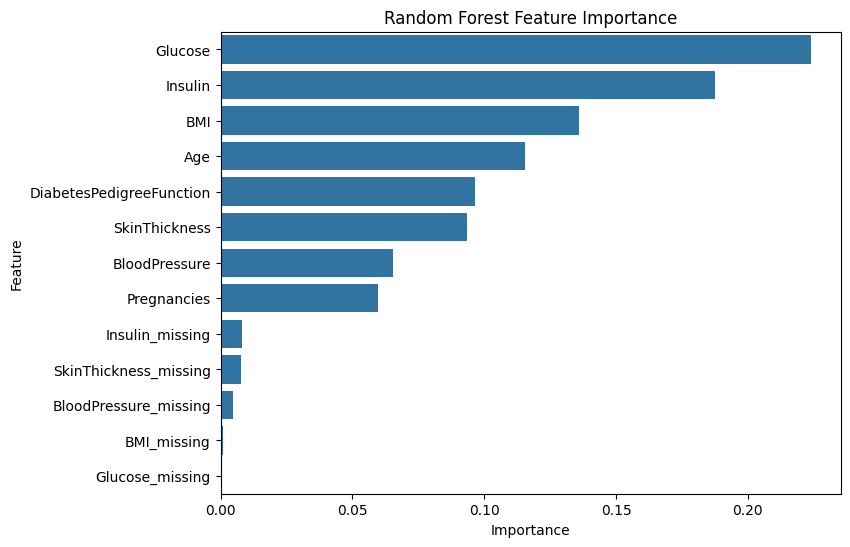

In [34]:
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': grid_rf.best_estimator_.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Random Forest):")
print(importances)

plt.figure(figsize=(8, 6))
sns.barplot(data=importances, x='Importance', y='Feature')
plt.title('Random Forest Feature Importance')
plt.show()

## 7.0 Summary and Implications
Summarize key findings from EDA and model evaluation, and discuss the model’s potential for early diabetes detection.